In [1]:
import sys
import os
sys.path.append("../../TychePlot/")
from OLEDPlot import OLEDPlot
from Filereader import fileToNpArray,npArrayToFile
import numpy as np

In [2]:
files=['plqy/16092020/20200916_red_plqy/Laser_1s_10rep_2020-09-16_11-27-33_', 'plqy/16092020/20200916_red_plqy/sample_1s_10rep_2020-09-16_11-31-24_', 'plqy/16092020/20200916_red_plqy/sample_out_of_beam_1s_10rep_2020-09-16_11-41-10_']

In [3]:
spectra_offset=[350,-1]
laser_thresh=500*10**-9

In [4]:
file_format={
                "skiplines":1,
                "fileEnding":".tsv",
                "separator":"\t",
                "commaToPoint":True,
            }
clbr_format={
                "skiplines":1,
                "fileEnding":".clbr",
                "separator":"\t",
                "commaToPoint":True,
            }

In [5]:
spectra=[]
for file in files:
    spectra.append(fileToNpArray(file, **file_format)[0])

In [6]:
calib_vec=fileToNpArray("plqy/calib/2020-09-04_13-56-01___CCD__Calibration", **clbr_format)[0][:,1][spectra_offset[0]:spectra_offset[1]]

In [7]:
c=2.99793*10**8
h=6.623*10**-34
hc=h*c

In [8]:
wavelengths=spectra[0][:,0][spectra_offset[0]:spectra_offset[1]]
laser=spectra[0][:,1][spectra_offset[0]:spectra_offset[1]]*calib_vec
sample=spectra[1][:,1][spectra_offset[0]:spectra_offset[1]]*calib_vec
laser_sample=spectra[2][:,1][spectra_offset[0]:spectra_offset[1]]*calib_vec
laser_thresh_index=np.argwhere(wavelengths > laser_thresh)[0][0]

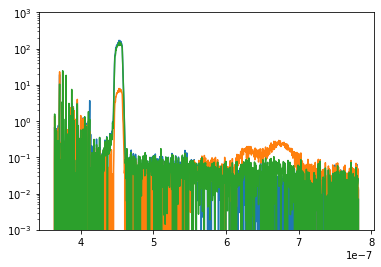

In [9]:

import scipy.interpolate as sci
import scipy.integrate as scin
import matplotlib.pyplot as plt
plt.plot(wavelengths, laser, wavelengths, sample, wavelengths, laser_sample)
plt.ylim(10**-3,10**3)
plt.yscale("log")

In [10]:
### PAPER CALCS

In [13]:
## Interpolation
P_a_spectral_func=sci.interp1d(wavelengths,laser, kind='cubic')
P_b_spectral_func=sci.interp1d(wavelengths,sample, kind='cubic')
P_c_spectral_func=sci.interp1d(wavelengths,laser_sample, kind='cubic')
# Integration
L_a, L_a_err=scin.quad(lambda a: a*P_a_spectral_func(a)/hc,wavelengths[0],laser_thresh, limit=5000)
L_b, L_b_err=scin.quad(lambda a: a*P_b_spectral_func(a)/hc,wavelengths[0],laser_thresh, limit=5000)
L_c, L_c_err=scin.quad(lambda a: a*P_c_spectral_func(a)/hc,wavelengths[0],laser_thresh, limit=5000)
P_a, P_a_err=scin.quad(lambda a: a*P_a_spectral_func(a)/hc,laser_thresh,wavelengths[-1], limit=5000)
P_b, P_b_err=scin.quad(lambda a: a*P_b_spectral_func(a)/hc,laser_thresh,wavelengths[-1], limit=5000)
P_c, P_c_err=scin.quad(lambda a: a*P_c_spectral_func(a)/hc,laser_thresh,wavelengths[-1], limit=5009)
# 2 Step
PLQY_2_step=(P_c)/(L_a-L_c)*100
# 3 Step
PLQY_3_step=(P_c-(L_c/L_b)*P_b)/(L_a*(1-L_c/L_b))*100
## Summation
delta_x=[]
for x in range(0,len(wavelengths)-1):
    delta_x.append(wavelengths[x+1]-wavelengths[x])
L_a_midpoint_riemann_sum_elements=[]
L_b_midpoint_riemann_sum_elements=[]
L_c_midpoint_riemann_sum_elements=[]
for x in range(0,len(delta_x)):
    L_a_midpoint_riemann_sum_elements.append(((laser[x]+laser[x+1])/2)*((wavelengths[x]+wavelengths[x+1])/2)/hc*delta_x[x])
    L_b_midpoint_riemann_sum_elements.append(((sample[x]+sample[x+1])/2)*((wavelengths[x]+wavelengths[x+1])/2)/hc*delta_x[x])
    L_c_midpoint_riemann_sum_elements.append(((laser_sample[x]+laser_sample[x+1])/2)*((wavelengths[x]+wavelengths[x+1])/2)/hc*delta_x[x])
L_a_sum=sum(L_a_midpoint_riemann_sum_elements[:laser_thresh_index])
L_b_sum=sum(L_b_midpoint_riemann_sum_elements[:laser_thresh_index])
L_c_sum=sum(L_c_midpoint_riemann_sum_elements[:laser_thresh_index])
P_a_sum=sum(L_a_midpoint_riemann_sum_elements[laser_thresh_index:])
P_b_sum=sum(L_b_midpoint_riemann_sum_elements[laser_thresh_index:])
P_c_sum=sum(L_c_midpoint_riemann_sum_elements[laser_thresh_index:])
# 2 Step
PLQY_2_step_sum=(P_c_sum)/(L_a_sum-L_c_sum)*100
# 3 Step
PLQY_3_step_sum=(P_c_sum-(L_c_sum/L_b_sum)*P_b_sum)/(L_a_sum*(1-L_c_sum/L_b_sum))*100
print(
    f"PLQY by Interpolation and Integration:\n"+
        f"\nPLQY by 2 Step: {PLQY_2_step:5.2f} %\nPLQY by 3 Step: {PLQY_3_step:5.2f} %\n"+
    f"\nPLQY by Summation:\n"+
    f"\nPLQY by 2 Step: {PLQY_2_step_sum:5.2f} %\nPLQY by 3 Step: {PLQY_3_step_sum:5.2f} %")

<ipython-input-13-71bbca7e7845>:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  L_a, L_a_err=scin.quad(lambda a: a*P_a_spectral_func(a)/hc,wavelengths[0],laser_thresh, limit=5000)
<ipython-input-13-71bbca7e7845>:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  L_b, L_b_err=scin.quad(lambda a: a*P_b_spectral_func(a)/hc,wavelengths[0],laser_thresh, limit=5000)
<ipython-input-13-71bbca7e7845>:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  L_c, L_c_err=scin.quad(lambda a: a*P_c_spectral_func(a)/hc,wavelengths[0],laser_thresh, limit=5000)
<ipython-input-13-71bbca7e7845>:9: IntegrationWarning: The occurrence of roundoff error is 

PLQY by Interpolation and Integration:

PLQY by 2 Step:  6.76 %
PLQY by 3 Step:  1.95 %

PLQY by Summation:

PLQY by 2 Step:  6.75 %
PLQY by 3 Step:  1.95 %


<ipython-input-13-71bbca7e7845>:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_c, P_c_err=scin.quad(lambda a: a*P_c_spectral_func(a)/hc,laser_thresh,wavelengths[-1], limit=5009)
